# Neural Networks Learn Atari Breakout

This notebook walks you through the setup 

## 1. Install Dependencies

Import the libraries that are needed for loading the environment. The following loads the necessary dependencies and checks the Python version (at runtime). ML-Agents Toolkit (v0.3 onwards) requires Python 3.

In [1]:
!pip3 install -q ./ml-agents/ml-agents
!pip3 install -q tensorflow==2.0.0-alpha0
# !pip3 install -q torch==1.0.1.post2

## 2. Load the environment

`UnityEnvironment` launches and begins communication with the environment when instantiated.

Environments contain _brains_ which are responsible for deciding the actions of their associated _agents_. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
import os
import numpy as np
from mlagents.envs import UnityEnvironment

env_name = "./env/linux/Breakout" 
unity_env = UnityEnvironment(file_name=env_name)

INFO:mlagents.envs:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 2
        Number of Training Brains : 1
        Reset Parameters :
		
Unity brain name: BreakoutLearning
        Number of Visual Observations (per agent): 0
        Vector Observation space size (per agent): 54
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): [3]
        Vector Action descriptions: 
Unity brain name: BreakoutPlayer
        Number of Visual Observations (per agent): 0
        Vector Observation space size (per agent): 54
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): [3]
        Vector Action descriptions: 


### 2.1 Examine the observation and state spaces

We can reset the environment to be provided with an initial set of observations and states for all the agents within the environment. In ML-Agents, _states_ refer to a vector of variables corresponding to relevant aspects of the environment for an agent. Likewise, _observations_ refer to a set of relevant pixel-wise visuals for an agent.

In this environment, a double-jointed arm can move to target locations. A reward of +0.1 is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of 33 variables corresponding to position, rotation, velocity, and angular velocities of the arm. Each action is a vector with four numbers, corresponding to torque applicable to two joints. Every entry in the action vector must be a number between -1 and 1.

Run the code cell below to print some information about the environment.

In [3]:
class GymEnv():
    def __init__(self, unity_env):
        self.env = unity_env
        self.default_brain = unity_env.brain_names[0]
        self.observation_space_size = unity_env.brains[self.default_brain].vector_observation_space_size
        self.action_space_size = int(unity_env.brains[self.default_brain].vector_action_space_size[0])
        
    def reset(self, train_mode=True):
        self.env_info = self.env.reset(train_mode=train_mode)[self.default_brain]
        return self.env_info.vector_observations[0]
    
    def step(self, action):
        self.env_info = self.env.step(action)[self.default_brain]
        next_state = self.env_info.vector_observations[0]
        reward = self.env_info.rewards[0]
        done = self.env_info.local_done[0]
        return next_state, reward, done, self.env_info
    
    def close(self):
        self.env.close()

env = GymEnv(unity_env)
action_size = env.action_space_size
state_size = env.observation_space_size
state = env.reset()

print('Number of actions:', action_size)
print('States have length:', state_size)
print('States look like:', state)

Number of actions: 3
States have length: 54
States look like: [ 0.          0.         -2.77063155  5.3219924   0.          0.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.        ]


## 3. Define the Reinforcement Learning Components

The next step is to define the components that make up the reinforcement learning algorithm. This requires defining:

- **3.1** The neural network architecture to approximate the Q function.
- **3.2** The experience replay buffer for storing and sampling batches of experience tuples.
- **3.3** The Q-Learning agent that samples from the replay buffer and trains the neural network.

#### 3.1.0 Neural Network Hyperparameters

In [ ]:
HIDDEN_SIZE = 500 #800
LEARNING_RATE = 0.0001 #0.0000625
TARGET_UPDATE_RATE = 0.001 #0.0005

####  3.1.1 Tensorflow QNetwork

Below is the implementation of a QNetwork using tensorflow as the backend model. This contains a tensorflow session and after initially building the network graph, it is trained by running the optimizer with the state, action and q_target values for training.

In [4]:
import tensorflow as tf
print("Tensorflow:", tf.__version__)

class TFModel(tf.keras.Model):
    def __init__(self, state_size, action_size):
        super().__init__()
        self.hidden1 = tf.keras.layers.Dense(HIDDEN_SIZE, activation=tf.nn.relu, kernel_initializer=tf.initializers.glorot_normal())
        self.hidden2 = tf.keras.layers.Dense(HIDDEN_SIZE, activation=tf.nn.relu, kernel_initializer=tf.initializers.glorot_normal())
        self.q_state = tf.keras.layers.Dense(action_size, activation=None, kernel_initializer=tf.initializers.glorot_normal())
        
    def call(self, state):
        hidden1 = self.hidden1(state)
        hidden2 = self.hidden2(hidden1) + hidden1
        q_state = self.q_state(hidden2)
        return q_state
    
class TFQNetwork():
    def __init__(self, state_size, action_size, load=False):
        self.model_local = TFModel(state_size, action_size)
        self.model_target = TFModel(state_size, action_size)
        self.optimizer = tf.optimizers.Adam(learning_rate=LEARNING_RATE)
        self.action_size = action_size
        if load: self.load_model()
        
    def get_q_state(self, state, use_target=False):
        model = self.model_local if not use_target else self.model_target
        return model(np.array(state)).numpy()
    
    def get_loss(self, states, actions, q_targets):
        actions_one_hot = tf.one_hot(actions, depth=self.action_size)
        q_states = tf.cast(self.model_local(states), tf.float32)
        q_states_actions = tf.reduce_sum(tf.multiply(q_states, actions_one_hot), axis=1)
        loss = tf.reduce_sum(tf.square(q_states_actions - q_targets))
        return loss
    
    def optimize(self, states, actions, q_targets):
        loss = lambda: self.get_loss(states, actions, q_targets)
        self.optimizer.minimize(loss=loss, var_list=self.model_local.trainable_weights)
        self.soft_copy(self.model_local, self.model_target)
        
    def soft_copy(self, local, target, tau=TARGET_UPDATE_RATE):
        new_target_vars = [t + tau*(l-t) for l,t in zip(local.get_weights(), target.get_weights())]
        self.model_target.set_weights(new_target_vars)
        
    def save_model(self, filepath="./saved_models/tensorflow2/model.tf"):
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        self.model_local.save_weights(filepath)
        
    def load_model(self, filepath="./saved_models/tensorflow2/model.tf"):
        if os.path.exists(filepath + ".index"):
            self.model_local.load_weights(filepath)
            self.model_target.load_weights(filepath)

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Tensorflow: 2.0.0-alpha0


#### 3.1.2 PyTorch QNetwork

Below is the implementation of a QNetwork using pytorch as the backend model. This involves first defining a Model class which subclasses the pytorch nn.Module class and then defines the network graph which can be run with the forward function.

Then the Model is included in an enclosing PTQNetwork class which trains the model by taking in the states and running the Model class to get the q values which are then indexed by the actions and then the gradients are calculated from the MSE loss between the predicted q value and the q_target.

In [5]:
import torch
print("PyTorch:", torch.__version__)

class PTModel(torch.nn.Module):
    def __init__(self, state_size, action_size):
        super().__init__()
        self.hidden1 = torch.nn.Linear(state_size, HIDDEN_SIZE)
        self.hidden2 = torch.nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE)
        self.q_state = torch.nn.Linear(HIDDEN_SIZE, action_size)
        torch.nn.init.xavier_normal_(self.hidden1.weight)
        torch.nn.init.xavier_normal_(self.hidden2.weight)
        torch.nn.init.xavier_normal_(self.q_state.weight)

    def forward(self, state):
        hidden1 = torch.nn.functional.relu(self.hidden1(state))
        hidden2 = torch.nn.functional.relu(self.hidden2(hidden1)) + hidden1
        q_state = self.q_state(hidden2)
        return q_state

class PTQNetwork():
    def __init__(self, state_size, action_size, load=False):
        self.model_local = PTModel(state_size, action_size)
        self.model_target = PTModel(state_size, action_size)
        self.optimizer = torch.optim.Adam(self.model_local.parameters(), lr=LEARNING_RATE)
        if load: self.load_model()

    def get_q_state(self, state, use_target=False):
        model = self.model_local if not use_target else self.model_target
        state = torch.from_numpy(np.array(state)).float()
        return model(state).detach().numpy()
    
    def get_loss(self, states, actions, q_targets):
        states = torch.from_numpy(np.vstack(states)).float()
        actions = torch.from_numpy(np.vstack(actions)).long()
        q_targets = torch.from_numpy(np.vstack(q_targets)).float()
        q_states_actions = self.model_local(states).gather(1, actions)
        loss = (q_states_actions - q_targets)**2
        return loss.mean()
    
    def optimize(self, states, actions, q_targets):
        loss = self.get_loss(states, actions, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.soft_copy(self.model_local, self.model_target)
        
    def soft_copy(self, local, target, tau=TARGET_UPDATE_RATE):
        for l,t in zip(local.parameters(), target.parameters()):
            t.data.copy_(t.data + tau*(l.data - t.data))
        
    def save_model(self, filepath="./saved_models/pytorch/checkpoint.pth"):
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        torch.save(self.model_local.state_dict(), filepath)
        
    def load_model(self, filepath="./saved_models/pytorch/checkpoint.pth"):
        if os.path.exists(filepath):
            self.model_local.load_state_dict(torch.load(filepath))
            self.model_target.load_state_dict(torch.load(filepath))

PyTorch: 0.4.0


### 3.2 Experience Replay

Below is the implementation of a Replay Buffer using the deque collection as the rolling buffer of experience tuples. This can be sampled by specifying the sample size and then returns each individual experience type as separate lists.

In [6]:
from collections import deque
import random

class ReplayBuffer():
    def __init__(self, maxlen):
        self.buffer = deque(maxlen=maxlen)
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        sample_size = min(len(self.buffer), batch_size)
        samples = random.choices(self.buffer, k=sample_size)
        return map(list, zip(*samples))

### 3.3 Q-Learning Algorithm

Below is the implementation of the agent that uses Deep Q Networks to learn the Bellman equation for selecting actions to take in a given state from the environment. It selects an action from an epsilon-greedy policy starting with eps = 1.0 which decreases as the network is trained.

#### 3.3.0 Q-Learning Hyperparameters

In [ ]:
MAX_BUFFER_SIZE = 1000000
REPLAY_BATCH_SIZE = 32
DISCOUNT_RATE = 0.99
EPS_MAX = 1.0
EPS_MIN = 0.1
EPS_DECAY = 0.998

#### 3.3.1 Q-Learning Agent

In [7]:
class DQNAgent():
    def __init__(self, state_size, action_size, network=TFQNetwork, eps=EPS_MAX, load=False):
        self.state_size = state_size
        self.action_size = action_size
        self.q_network = network(state_size, action_size, load)
        self.replay_buffer = ReplayBuffer(MAX_BUFFER_SIZE)
        self.eps = eps
        self.gamma = DISCOUNT_RATE

    def get_action(self, state, eps=None):
        eps = self.eps if eps == None else eps
        action_greedy = np.argmax(self.q_network.get_q_state([state]))
        action_random = np.random.randint(self.action_size)
        action = action_random if random.random() < eps else action_greedy
        return action
        
    def train(self, state, action, next_state, reward, done):
        self.replay_buffer.add((state, action, next_state, reward, done))
        states, actions, next_states, rewards, dones = self.replay_buffer.sample(REPLAY_BATCH_SIZE)
        
        next_actions = np.argmax(self.q_network.get_q_state(next_states, use_target=False), axis=1)
        q_next_states = self.q_network.get_q_state(next_states, use_target=True)
        q_next_states[dones] = np.zeros([self.action_size])
        q_next_states_next_actions = q_next_states[np.arange(next_actions.shape[0]), next_actions]
        q_targets = rewards + self.gamma * q_next_states_next_actions
        self.q_network.optimize(states, actions, q_targets)

        if done: self.eps = max(self.eps * EPS_DECAY, EPS_MIN)

## 4. Train the Agent

Below is the training loop for training the agent through a number of episodes of interacting with the environment. It keeps track of the total reward from each episode and also stores the last 100 episode rewards for calculating the average reward for checking when the environment was solved.

In [ ]:
networks = [TFQNetwork, PTQNetwork]
agent = DQNAgent(state_size, action_size, network=networks[0], load=False)

scores = []
scores_buffer = deque(maxlen=100)
avg_scores = []
num_episodes = 1200

for ep in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        agent.train(state, action, next_state, reward, done)
        total_reward += reward  
        state = next_state 

    scores.append(total_reward)
    scores_buffer.append(total_reward)
    avg_scores.append(np.mean(scores_buffer))
    print("Episode: {}, Score: {}, Avg reward: {:.2f}".format(ep, scores[-1], avg_scores[-1]))

    if ep % 100 == 99: agent.q_network.save_model()

Episode: 0, Score: -44.0, Avg reward: -44.00
Episode: 1, Score: -46.0, Avg reward: -45.00
Episode: 2, Score: -46.0, Avg reward: -45.33
Episode: 3, Score: -44.0, Avg reward: -45.00
Episode: 4, Score: -48.0, Avg reward: -45.60
Episode: 5, Score: -44.0, Avg reward: -45.33
Episode: 6, Score: -12.0, Avg reward: -40.57
Episode: 7, Score: -40.0, Avg reward: -40.50
Episode: 8, Score: -44.0, Avg reward: -40.89
Episode: 9, Score: -48.0, Avg reward: -41.60
Episode: 10, Score: -48.0, Avg reward: -42.18
Episode: 11, Score: -46.0, Avg reward: -42.50
Episode: 12, Score: -42.0, Avg reward: -42.46
Episode: 13, Score: -44.0, Avg reward: -42.57
Episode: 14, Score: -48.0, Avg reward: -42.93
Episode: 15, Score: -46.0, Avg reward: -43.12
Episode: 16, Score: -46.0, Avg reward: -43.29
Episode: 17, Score: -42.0, Avg reward: -43.22
Episode: 18, Score: -18.0, Avg reward: -41.89
Episode: 19, Score: -48.0, Avg reward: -42.20
Episode: 20, Score: -46.0, Avg reward: -42.38
Episode: 21, Score: -46.0, Avg reward: -42.5

Episode: 177, Score: -46.0, Avg reward: -44.46
Episode: 178, Score: -40.0, Avg reward: -44.42
Episode: 179, Score: -46.0, Avg reward: -44.44
Episode: 180, Score: -34.0, Avg reward: -44.34
Episode: 181, Score: -46.0, Avg reward: -44.34
Episode: 182, Score: -46.0, Avg reward: -44.32
Episode: 183, Score: -46.0, Avg reward: -44.36
Episode: 184, Score: -10.0, Avg reward: -44.00
Episode: 185, Score: -48.0, Avg reward: -44.10
Episode: 186, Score: -46.0, Avg reward: -44.14
Episode: 187, Score: -42.0, Avg reward: -44.14
Episode: 188, Score: -46.0, Avg reward: -44.14
Episode: 189, Score: -46.0, Avg reward: -44.48
Episode: 190, Score: -44.0, Avg reward: -44.46
Episode: 191, Score: -46.0, Avg reward: -44.44
Episode: 192, Score: -42.0, Avg reward: -44.40
Episode: 193, Score: -16.0, Avg reward: -44.16
Episode: 194, Score: -44.0, Avg reward: -44.18
Episode: 195, Score: -46.0, Avg reward: -44.18
Episode: 196, Score: -48.0, Avg reward: -44.22
Episode: 197, Score: -44.0, Avg reward: -44.26
Episode: 198,

Episode: 352, Score: -44.0, Avg reward: -42.90
Episode: 353, Score: -44.0, Avg reward: -42.90
Episode: 354, Score: -48.0, Avg reward: -42.94
Episode: 355, Score: -36.0, Avg reward: -42.88
Episode: 356, Score: -44.0, Avg reward: -42.96
Episode: 357, Score: -46.0, Avg reward: -43.44
Episode: 358, Score: -44.0, Avg reward: -43.42
Episode: 359, Score: -42.0, Avg reward: -43.38
Episode: 360, Score: 4.0, Avg reward: -42.86
Episode: 361, Score: -44.0, Avg reward: -42.90
Episode: 362, Score: -44.0, Avg reward: -42.86
Episode: 363, Score: -44.0, Avg reward: -42.88
Episode: 364, Score: -46.0, Avg reward: -42.90
Episode: 365, Score: -46.0, Avg reward: -42.94
Episode: 366, Score: -46.0, Avg reward: -42.92
Episode: 367, Score: -44.0, Avg reward: -42.92
Episode: 368, Score: -34.0, Avg reward: -42.96
Episode: 369, Score: -46.0, Avg reward: -42.98
Episode: 370, Score: -36.0, Avg reward: -42.88
Episode: 371, Score: -46.0, Avg reward: -42.90
Episode: 372, Score: -46.0, Avg reward: -42.94
Episode: 373, S

Episode: 527, Score: -16.0, Avg reward: -34.82
Episode: 528, Score: -40.0, Avg reward: -34.74
Episode: 529, Score: -46.0, Avg reward: -34.80
Episode: 530, Score: -20.0, Avg reward: -34.56
Episode: 531, Score: -30.0, Avg reward: -34.42
Episode: 532, Score: 2.0, Avg reward: -34.02
Episode: 533, Score: -16.0, Avg reward: -33.82
Episode: 534, Score: -6.0, Avg reward: -33.60
Episode: 535, Score: -38.0, Avg reward: -33.52
Episode: 536, Score: -40.0, Avg reward: -33.48
Episode: 537, Score: -38.0, Avg reward: -33.42
Episode: 538, Score: -12.0, Avg reward: -33.08
Episode: 539, Score: -14.0, Avg reward: -32.76
Episode: 540, Score: -6.0, Avg reward: -32.38
Episode: 541, Score: -36.0, Avg reward: -32.32
Episode: 542, Score: -2.0, Avg reward: -32.02
Episode: 543, Score: 8.0, Avg reward: -31.50
Episode: 544, Score: -28.0, Avg reward: -31.44
Episode: 545, Score: -6.0, Avg reward: -31.02
Episode: 546, Score: -28.0, Avg reward: -30.94
Episode: 547, Score: -2.0, Avg reward: -30.54
Episode: 548, Score: -

In [ ]:
networks = [TFQNetwork, PTQNetwork]
agent = DQNAgent(state_size, action_size, network=networks[0], eps=0.0, load=True)

scores = []
scores_buffer = deque(maxlen=100)
avg_scores = []
num_episodes = 1000

for ep in range(600, num_episodes):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        agent.train(state, action, next_state, reward, done)
        total_reward += reward  
        state = next_state 

    scores.append(total_reward)
    scores_buffer.append(total_reward)
    avg_scores.append(np.mean(scores_buffer))
    print("Episode: {}, Score: {}, Avg reward: {:.2f}".format(ep, scores[-1], avg_scores[-1]))

    if ep % 100 == 99: agent.q_network.save_model("./saved_models/temp/model_{}.tf".format(ep))

Episode: 600, Score: -18.0, Avg reward: -18.00
Episode: 601, Score: -16.0, Avg reward: -17.00
Episode: 602, Score: -24.0, Avg reward: -19.33
Episode: 603, Score: -8.0, Avg reward: -16.50
Episode: 604, Score: -22.0, Avg reward: -17.60
Episode: 605, Score: -38.0, Avg reward: -21.00
Episode: 606, Score: -22.0, Avg reward: -21.14
Episode: 607, Score: 34.0, Avg reward: -14.25
Episode: 608, Score: 18.0, Avg reward: -10.67
Episode: 609, Score: -18.0, Avg reward: -11.40
Episode: 610, Score: 26.0, Avg reward: -8.00
Episode: 611, Score: 34.0, Avg reward: -4.50
Episode: 612, Score: 42.0, Avg reward: -0.92
Episode: 613, Score: 4.0, Avg reward: -0.57
Episode: 614, Score: 28.0, Avg reward: 1.33
Episode: 615, Score: -46.0, Avg reward: -1.62
Episode: 616, Score: -30.0, Avg reward: -3.29
Episode: 617, Score: 22.0, Avg reward: -1.89
Episode: 618, Score: 42.0, Avg reward: 0.42
Episode: 619, Score: -38.0, Avg reward: -1.50
Episode: 620, Score: 2.0, Avg reward: -1.33
Episode: 621, Score: -4.0, Avg reward: 

Episode: 785, Score: -6.0, Avg reward: 1.98
Episode: 786, Score: 26.0, Avg reward: 2.06
Episode: 787, Score: 28.0, Avg reward: 2.74
Episode: 788, Score: 46.0, Avg reward: 3.42
Episode: 789, Score: 38.0, Avg reward: 4.00
Episode: 790, Score: 44.0, Avg reward: 4.06
Episode: 791, Score: -24.0, Avg reward: 3.44
Episode: 792, Score: -30.0, Avg reward: 3.26
Episode: 793, Score: 26.0, Avg reward: 3.94
Episode: 794, Score: -46.0, Avg reward: 3.24
Episode: 795, Score: 46.0, Avg reward: 3.42
Episode: 796, Score: -18.0, Avg reward: 3.42
Episode: 797, Score: 58.0, Avg reward: 4.24
Episode: 798, Score: -16.0, Avg reward: 4.40
Episode: 799, Score: 40.0, Avg reward: 5.20
Episode: 800, Score: -12.0, Avg reward: 4.86
Episode: 801, Score: 58.0, Avg reward: 5.84
Episode: 802, Score: 58.0, Avg reward: 6.86
Episode: 803, Score: -12.0, Avg reward: 6.96
Episode: 804, Score: 44.0, Avg reward: 7.54
Episode: 805, Score: 2.0, Avg reward: 7.14
Episode: 806, Score: 8.0, Avg reward: 6.92
Episode: 807, Score: 46.0, 

### 4.1 Plotting the training rewards

The plot below shows the total reward from each episode (blue) and the average reward over the last 100 episodes (orange). We can see that the agent was able to reach the average reward of 13 after about 600 episodes.

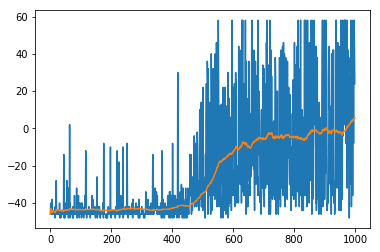

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

x = range(len(scores))
plt.plot(x,scores, x,avg_scores)

## 5. Test the Agent

The cell below creates a test agent loading the trained weights for a test run of the environment with the trained model. Change the num_episodes variable to run the simulation and calculate the average reward total over multiple episodes.

In [29]:
test_agent = DQNAgent(state_size, action_size, load=True)

for ep in range(1):
    state = env.reset(train_mode=False)
    total_reward = 0
    done = False
    while not done:
        action = test_agent.get_action(state, eps=0.0)
        next_state, reward, done, info = env.step(action)
        total_reward += reward  
        state = next_state 
    print("Episode: {}, Score: {}".format(ep, total_reward))

Episode: 0, Score: 58.0


## 6. Close the environment when finished
When we are finished using an environment, we can close it with the function below.

In [3]:
env.close()